Sachsen-Anhalt n = 1430
Thüringen       n = 1727

=== Permutation test: condition rating (Zustandsnote, SA - TH) ===
Observed mean difference: 0.3506
Two-sided p-value       : 0.000050

=== Baujahr Überbau (SA - TH) ===
Mean diff perm-test   : obs = 0.5252, p = 0.503825
Welch-t perm-test     : obs = 0.6826, p = 0.496775

=== Länge (m) (SA - TH) ===
Mean diff perm-test   : obs = -3.2634, p = 0.394030
Welch-t perm-test     : obs = -0.8611, p = 0.388481

Length IQR (pooled): Q25 = 6.74, Q75 = 45.81
Sachsen-Anhalt (IQR length) n = 692
Thüringen       (IQR length) n = 888

=== Länge (m) (SA - TH) | length Q25–Q75 ===
Mean diff perm-test   : obs = 0.8571, p = 0.132643
Welch-t perm-test     : obs = 1.5050, p = 0.133893

=== Baujahr Überbau (SA - TH) | length Q25–Q75 ===
Mean diff perm-test   : obs = 1.3945, p = 0.158542
Welch-t perm-test     : obs = 1.4667, p = 0.142093

=== Zustandsnote (SA - TH) | length Q25–Q75 ===
Mean diff perm-test   : obs = 0.3476, p = 0.000050
Welch-t perm-test     : 

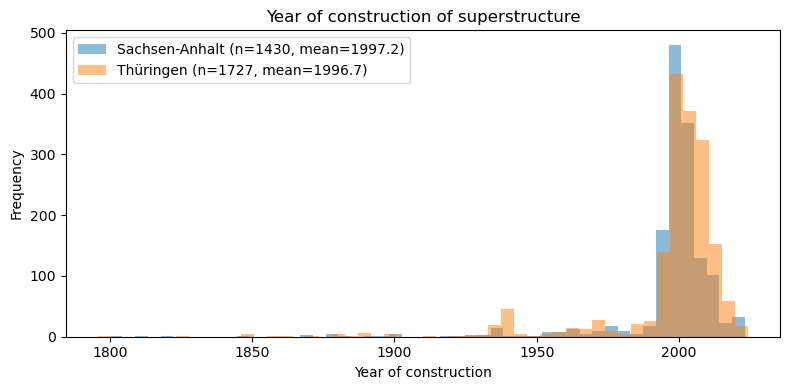

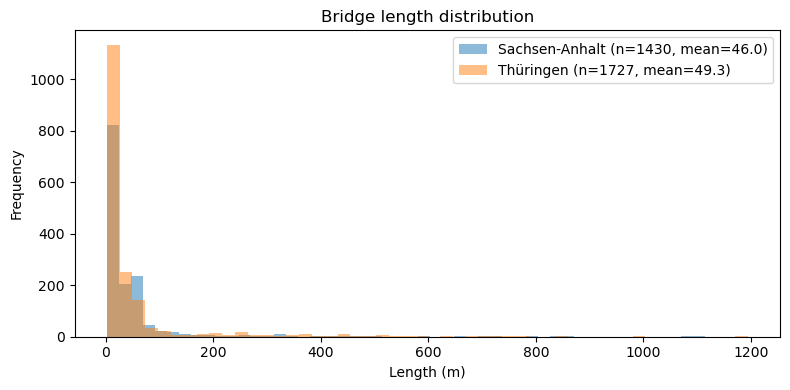


Bin sizes (per state):
                count       mean         std   min   25%   50%   75%    max
State                                                                      
Sachsen-Anhalt   18.0  73.388889   77.056235  11.0  23.0  43.5  82.5  274.0
Thüringen        16.0  96.750000  119.947489  13.0  29.0  49.5  82.0  450.0


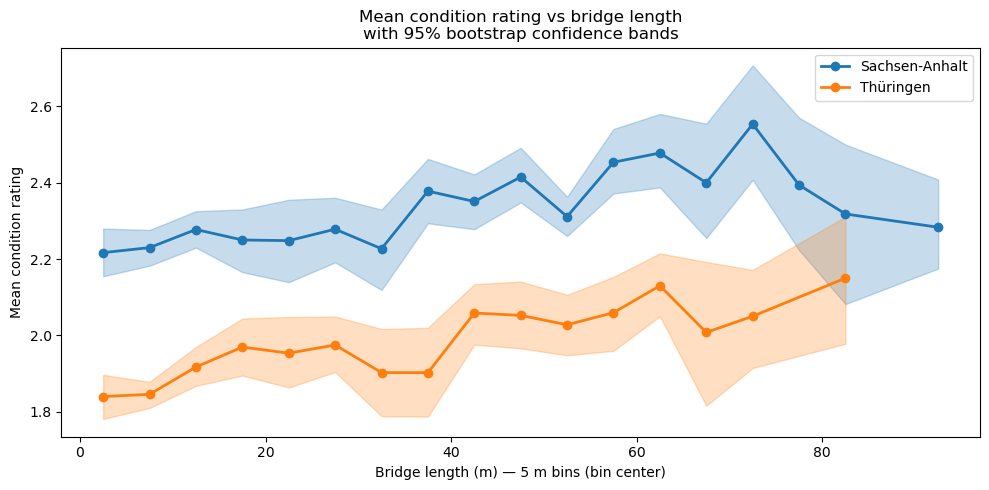

In [1]:
# Imports & data loading

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Adjust path if needed
path = "../../data/final_bridge_statistic_germany.csv"

df = pd.read_csv(path, sep=";", encoding="latin1")

# Fix some broken umlauts in column names
df.columns = (
    df.columns
      .str.replace("Ã¤", "ä", regex=False)
      .str.replace("Ã¼", "ü", regex=False)
      .str.replace("Ã¶", "ö", regex=False)
      .str.replace("Ã\x9c", "Ü", regex=False)
      .str.replace("Ã\x9f", "ß", regex=False)
)

df = df.rename(columns={"Baujahr Ã\x9cberbau": "Baujahr Überbau"})

#  Numeric conversion

num_cols = ["Zustandsnote", "Baujahr Überbau", "Länge (m)"]
for col in num_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Restrict to the two states of interest
sa_mask = df["Bundeslandname"].isin(["Sachsen-Anhalt", "Sachsen Anhalt"])
th_mask = df["Bundeslandname"].isin(["Thüringen", "Thueringen"])

d_sa = df.loc[sa_mask, num_cols].copy()
d_th = df.loc[th_mask, num_cols].copy()

print(f"Sachsen-Anhalt n = {len(d_sa)}")
print(f"Thüringen       n = {len(d_th)}")

# --- Helper functions: permutation tests ---

def perm_test_mean_diff(x, y, n_perm=20000, seed=1):
    """Two-sided permutation test for difference in means."""
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]

    obs = x.mean() - y.mean()
    pooled = np.concatenate([x, y])
    n_x = x.size

    null_stats = np.empty(n_perm, dtype=float)
    for i in range(n_perm):
        perm = rng.permutation(pooled)
        null_stats[i] = perm[:n_x].mean() - perm[n_x:].mean()

    p = (np.sum(np.abs(null_stats) >= abs(obs)) + 1) / (n_perm + 1)
    return obs, p

def welch_t_stat(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    mx, my = x.mean(), y.mean()
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    return (mx - my) / np.sqrt(vx/len(x) + vy/len(y))

def perm_test_welch_t(x, y, n_perm=20000, seed=1):
    """Permutation test using Welch's t-statistic as test statistic."""
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]

    obs = welch_t_stat(x, y)
    pooled = np.concatenate([x, y])
    n_x = x.size

    null_stats = np.empty(n_perm, dtype=float)
    for i in range(n_perm):
        perm = rng.permutation(pooled)
        x_p = perm[:n_x]
        y_p = perm[n_x:]
        null_stats[i] = welch_t_stat(x_p, y_p)

    p = (np.sum(np.abs(null_stats) >= abs(obs)) + 1) / (n_perm + 1)
    return obs, p

# --- 1) Permutation test: condition rating (Zustandsnote) ---

z_sa = d_sa["Zustandsnote"].values
z_th = d_th["Zustandsnote"].values

obs_z, p_z = perm_test_mean_diff(z_sa, z_th, n_perm=20000, seed=1)

print("\n=== Permutation test: condition rating (Zustandsnote, SA - TH) ===")
print(f"Observed mean difference: {obs_z:.4f}")
print(f"Two-sided p-value       : {p_z:.6f}")

# --- 2) Tests for age (Baujahr Überbau) and length (Länge (m)) ---

for var in ["Baujahr Überbau", "Länge (m)"]:
    x = d_sa[var].values
    y = d_th[var].values

    obs_md, p_md = perm_test_mean_diff(x, y, n_perm=20000, seed=1)
    obs_t, p_t = perm_test_welch_t(x, y, n_perm=20000, seed=1)

    print(f"\n=== {var} (SA - TH) ===")
    print(f"Mean diff perm-test   : obs = {obs_md:.4f}, p = {p_md:.6f}")
    print(f"Welch-t perm-test     : obs = {obs_t:.4f}, p = {p_t:.6f}")

# --- 3) Length IQR restriction (25–75% quantiles) ---

# Pooled length distribution for both states
length_all = pd.concat([d_sa["Länge (m)"], d_th["Länge (m)"]], ignore_index=True)
q25, q75 = length_all.quantile([0.25, 0.75])

print(f"\nLength IQR (pooled): Q25 = {q25:.2f}, Q75 = {q75:.2f}")

# Restrict to this central length band
sa_q = d_sa[(d_sa["Länge (m)"] >= q25) & (d_sa["Länge (m)"] <= q75)]
th_q = d_th[(d_th["Länge (m)"] >= q25) & (d_th["Länge (m)"] <= q75)]

print(f"Sachsen-Anhalt (IQR length) n = {len(sa_q)}")
print(f"Thüringen       (IQR length) n = {len(th_q)}")

# Tests within IQR band
for var in ["Länge (m)", "Baujahr Überbau", "Zustandsnote"]:
    x = sa_q[var].values
    y = th_q[var].values

    obs_md, p_md = perm_test_mean_diff(x, y, n_perm=20000, seed=1)
    obs_t, p_t = perm_test_welch_t(x, y, n_perm=20000, seed=1)

    print(f"\n=== {var} (SA - TH) | length Q25–Q75 ===")
    print(f"Mean diff perm-test   : obs = {obs_md:.4f}, p = {p_md:.6f}")
    print(f"Welch-t perm-test     : obs = {obs_t:.4f}, p = {p_t:.6f}")

# --- 4) Histograms: year of construction and length ---

def hist_compare(sa_series, th_series, title, xlabel, bins=40):
    x_sa = sa_series.dropna().to_numpy()
    x_th = th_series.dropna().to_numpy()

    plt.figure(figsize=(8, 4))
    plt.hist(x_sa, bins=bins, alpha=0.5, density=False,
             label=f"Sachsen-Anhalt (n={len(x_sa)}, mean={x_sa.mean():.1f})")
    plt.hist(x_th, bins=bins, alpha=0.5, density=False,
             label=f"Thüringen (n={len(x_th)}, mean={x_th.mean():.1f})")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

hist_compare(d_sa["Baujahr Überbau"], d_th["Baujahr Überbau"],
             "Year of construction of superstructure", "Year of construction", bins=50)

hist_compare(d_sa["Länge (m)"], d_th["Länge (m)"],
             "Bridge length distribution", "Length (m)", bins=50)

# --- 5) Length vs condition rating with bootstrap CI ---

# Combine data from both states into one table
use = df.loc[sa_mask | th_mask, ["Bundeslandname", "Zustandsnote", "Länge (m)"]].dropna().copy()
use["State"] = np.where(
    use["Bundeslandname"].isin(["Sachsen-Anhalt", "Sachsen Anhalt"]),
    "Sachsen-Anhalt",
    "Thüringen"
)

# Length bins (2 m width)
bin_width = 5.0
max_len = float(use["Länge (m)"].max())
max_edge = np.ceil(max_len / bin_width) * bin_width
edges = np.arange(0, max_edge + bin_width, bin_width)

use["length_bin"] = pd.cut(use["Länge (m)"],
                           bins=edges,
                           right=False,
                           include_lowest=True)

# Bin midpoints
bin_midpoints = {b: (b.left + b.right) / 2 for b in use["length_bin"].cat.categories}

def bootstrap_mean_ci(x, n_boot=2000, ci=95, seed=1):
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan, np.nan
    means = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        samp = rng.choice(x, size=n, replace=True)
        means[i] = samp.mean()
    alpha = (100 - ci) / 2
    lo, hi = np.percentile(means, [alpha, 100 - alpha])
    return x.mean(), lo, hi

min_n_per_bin = 10   # minimal n per state & bin

rows = []
for state in ["Sachsen-Anhalt", "Thüringen"]:
    sub = use[use["State"] == state]
    for b, g in sub.groupby("length_bin", observed=True):
        if len(g) < min_n_per_bin:
            continue
        m, lo, hi = bootstrap_mean_ci(g["Zustandsnote"].values,
                                      n_boot=2000, ci=95, seed=1)
        rows.append({
            "State": state,
            "bin": b,
            "x": bin_midpoints[b],
            "n": len(g),
            "mean": m,
            "lo": lo,
            "hi": hi
        })

res = pd.DataFrame(rows).sort_values(["State", "x"])
print("\nBin sizes (per state):")
print(res.groupby("State")["n"].describe())

plt.figure(figsize=(10, 5))

for state in ["Sachsen-Anhalt", "Thüringen"]:
    r = res[res["State"] == state].sort_values("x")
    if r.empty:
        continue
    line = plt.plot(r["x"], r["mean"], marker="o", linewidth=2, label=state)[0]
    c = line.get_color()
    plt.fill_between(r["x"], r["lo"], r["hi"], alpha=0.25, color=c)

plt.xlabel("Bridge length (m) — 5 m bins (bin center)")
plt.ylabel("Mean condition rating")
plt.title("Mean condition rating vs bridge length\nwith 95% bootstrap confidence bands")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/zj/y_y97nk968x1fwv19z05cpf80000gn/T/ipykernel_23682/2291029218.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


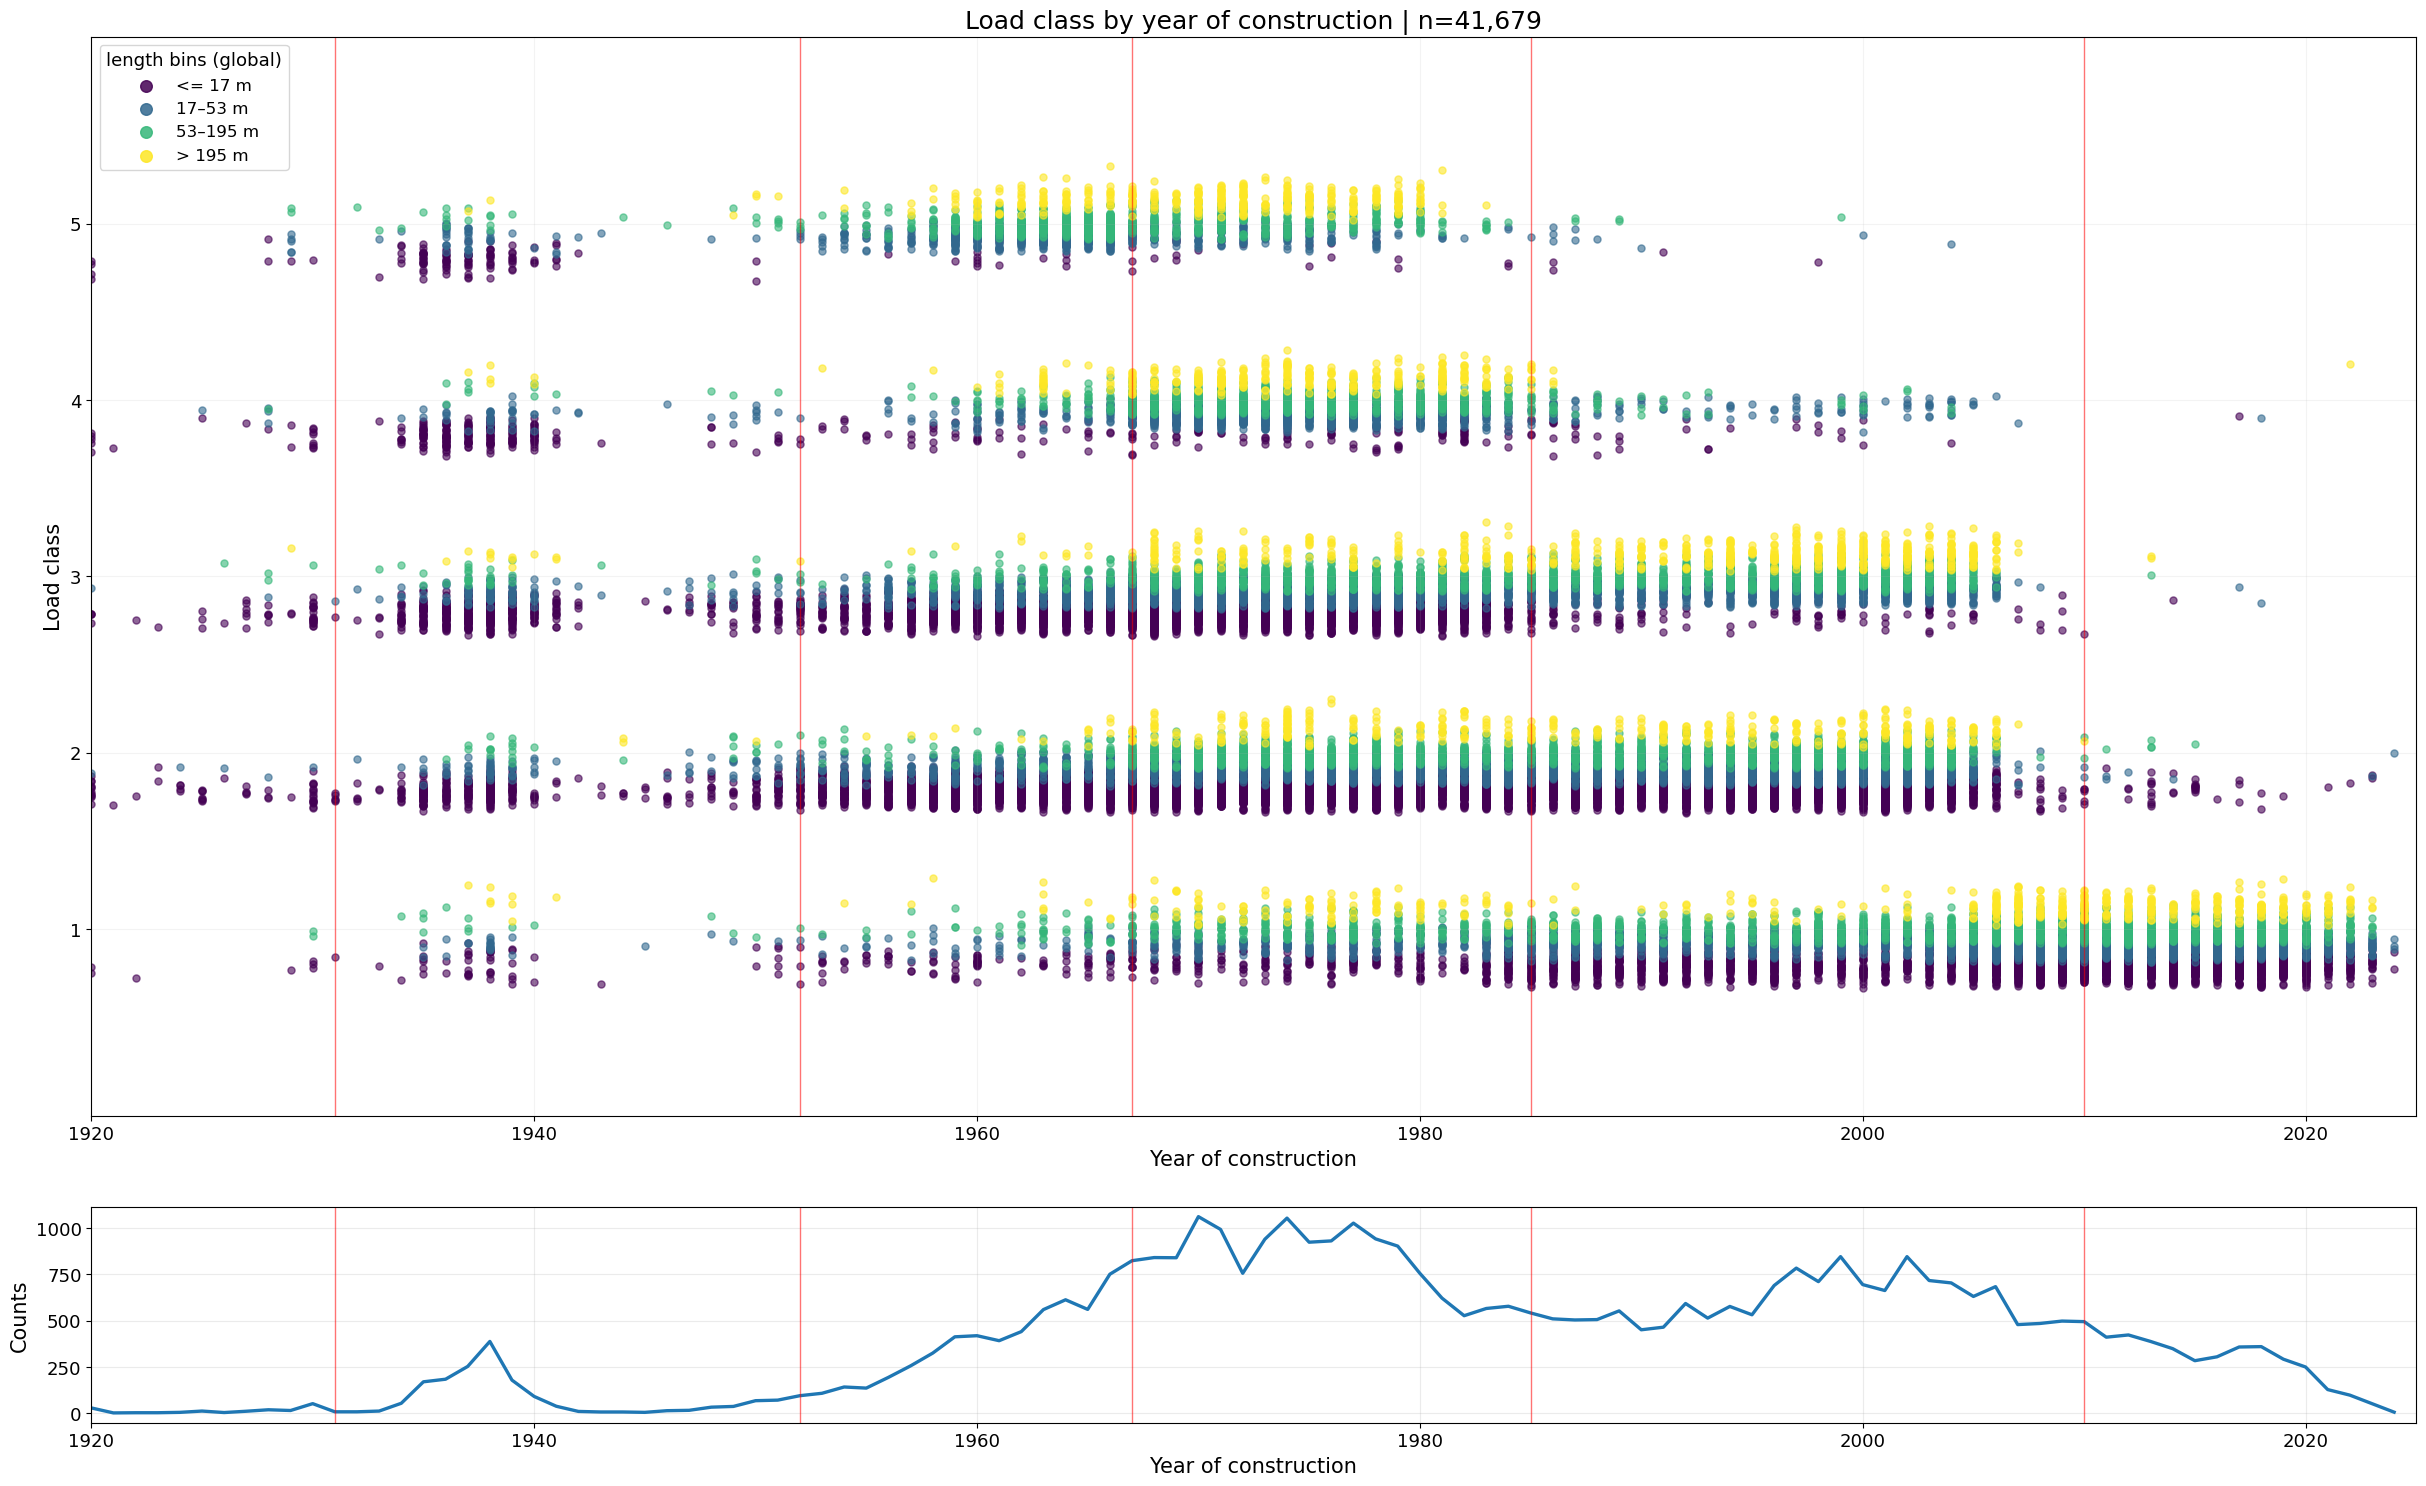

In [3]:
# Imports & data loading

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Adjust path if needed
path = "../../data/final_bridge_statistic_germany.csv"

df = pd.read_csv(path, sep=";", encoding="latin1")

# Fix some broken umlauts in column names
df.columns = (
    df.columns
      .str.replace("Ã¤", "ä", regex=False)
      .str.replace("Ã¼", "ü", regex=False)
      .str.replace("Ã¶", "ö", regex=False)
      .str.replace("Ã\x9c", "Ü", regex=False)
      .str.replace("Ã\x9f", "ß", regex=False)
)

df = df.rename(columns={"Baujahr Ã\x9cberbau": "Baujahr Überbau"})

#  Numeric conversion

num_cols = ["Zustandsnote", "Baujahr Überbau", "Länge (m)"]
for col in num_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# === One cell: prepare bridge-level data + ONE combined plot (A+B) in English ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def prepare_bridge_level_data(df):
    df = df.copy()

    needed_cols = [
        "Bauwerksname", "Bundeslandname", "Zugeordneter Sachverhalt vereinfacht",
        "Baujahr Überbau", "Baujahr Unterbau", "Traglastindex",
        "Länge (m)", "Breite (m)"
    ]
    missing = [c for c in needed_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    # numeric conversion
    for c in ["Breite (m)", "Länge (m)", "Traglastindex", "Baujahr Überbau", "Baujahr Unterbau"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # remove entire bridges if any row has width > 100
    bad_bridges = df.loc[df["Breite (m)"] > 100, "Bauwerksname"].dropna().unique()
    df = df[~df["Bauwerksname"].isin(bad_bridges)].copy()

    # each bridge must map to exactly one federal state
    bl_nunique = df.groupby("Bauwerksname")["Bundeslandname"].nunique(dropna=False)
    bad_bl = bl_nunique[bl_nunique > 1].index
    df = df[~df["Bauwerksname"].isin(bad_bl)].copy()

    # row area
    df["area_m2_row"] = df["Länge (m)"] * df["Breite (m)"]

    # aggregate to bridge level
    bridges = df.groupby("Bauwerksname", dropna=True).agg(
        LoadIndex_min=("Traglastindex", "min"),
        Year_superstructure_min=("Baujahr Überbau", "min"),
        Year_substructure_min=("Baujahr Unterbau", "min"),
        Area_m2_sum=("area_m2_row", "sum"),
        Length_m_sum=("Länge (m)", "sum"),
        FederalState=("Bundeslandname", "first"),
        Dataset=("Zugeordneter Sachverhalt vereinfacht", "first"),
    ).reset_index()

    # filters
    bridges = bridges[np.isfinite(bridges["LoadIndex_min"])].copy()
    bridges = bridges[np.isfinite(bridges["Year_superstructure_min"])].copy()
    bridges = bridges[np.isfinite(bridges["Area_m2_sum"])].copy()
    bridges = bridges[bridges["Area_m2_sum"] > 0].copy()

    bridges["Year_superstructure_min"] = pd.to_numeric(
        bridges["Year_superstructure_min"], errors="coerce"
    ).astype(int)

    return bridges

def plot_load_by_year_one_plot(cfg, df_bridge, title):
    d = df_bridge.copy()

    d["year"] = pd.to_numeric(d[cfg["year_col"]], errors="coerce")
    d["y"] = pd.to_numeric(d[cfg["load_col"]], errors="coerce")

    if cfg["size_var"] == "area":
        d["size_val"] = pd.to_numeric(d[cfg["area_col"]], errors="coerce")
        size_label = "m²"
    elif cfg["size_var"] == "length":
        d["size_val"] = pd.to_numeric(d[cfg["length_col"]], errors="coerce")
        size_label = "m"
    else:
        raise ValueError("cfg['size_var'] must be 'area' or 'length'")

    d = d[np.isfinite(d["year"]) & np.isfinite(d["y"]) & np.isfinite(d["size_val"])].copy()
    d["year"] = d["year"].astype(int)
    d = d[(d["year"] >= cfg["year_min"]) & (d["year"] <= cfg["year_max"])].copy()

    if len(d) == 0:
        print(f"{title}: no data in range {cfg['year_min']}-{cfg['year_max']}")
        return

    # global thresholds based on size_val
    q50, q80, q95 = np.quantile(d["size_val"].to_numpy(), cfg["q_bins"])
    d["bin"] = 0
    d.loc[d["size_val"] > q50, "bin"] = 1
    d.loc[d["size_val"] > q80, "bin"] = 2
    d.loc[d["size_val"] > q95, "bin"] = 3

    # vertical offset using log(size)
    rng = np.random.default_rng(cfg["seed"])
    lv = np.log1p(d["size_val"].to_numpy())
    lv_min, lv_max = lv.min(), lv.max()
    norm = np.zeros_like(lv) if lv_max == lv_min else (lv - lv_min) / (lv_max - lv_min)

    d["y_base"] = d["y"] * cfg["y_gap"]
    d["offset"] = (norm - 0.5) * cfg["y_span"] + rng.uniform(
        -cfg["jitter_base"], cfg["jitter_base"], size=len(d)
    )

    fig, axes = plt.subplots(
        2, 1,
        figsize=cfg["figsize"],
        gridspec_kw={"height_ratios": cfg["height_ratios"], "hspace": cfg["hspace"]}
    )
    ax = axes[0]
    ax_line = axes[1]

    cmap = plt.get_cmap(cfg["cmap"], 4)

    # scatter by bins
    for b in [0, 1, 2, 3]:
        sb = d[d["bin"] == b]
        if len(sb) == 0:
            continue
        ax.scatter(
            sb["year"],
            sb["y_base"] + sb["offset"],
            c=[cmap(b)],
            s=cfg["point_size"],
            alpha=cfg["point_alpha"]
        )

    # vertical code-change lines
    for yr in cfg["code_change_years"]:
        if cfg["year_min"] <= yr <= cfg["year_max"]:
            ax.axvline(
                yr, linewidth=cfg["vline_width"], alpha=cfg["vline_alpha"],
                linestyle="-", color=cfg["vline_color"]
            )

    ax.set_title(f"{title} | n={len(d):,}", fontsize=cfg["title_fs"])
    ax.set_xlabel(cfg["xlabel"], fontsize=cfg["label_fs"])
    ax.set_ylabel(cfg["ylabel"], fontsize=cfg["label_fs"])
    ax.set_xlim(cfg["year_min"], cfg["year_max"])
    ax.grid(True, alpha=cfg["grid_alpha"])

    y_levels = sorted(d["y"].dropna().unique())
    ax.set_yticks([y * cfg["y_gap"] for y in y_levels])
    ax.set_yticklabels(
        [str(int(y)) if float(y).is_integer() else str(y) for y in y_levels],
        fontsize=cfg["tick_fs"]
    )
    ax.tick_params(axis="x", labelsize=cfg["tick_fs"])
    ax.set_ylim(
        d["y_base"].min() - (cfg["y_span"] + cfg["y_pad"]),
        d["y_base"].max() + (cfg["y_span"] + cfg["y_pad"])
    )

    # legend
    handles = [ax.scatter([], [], c=[cmap(b)], s=cfg["legend_point_size"], alpha=0.85) for b in [0, 1, 2, 3]]
    labels = [
        f"<= {q50:.0f} {size_label}",
        f"{q50:.0f}–{q80:.0f} {size_label}",
        f"{q80:.0f}–{q95:.0f} {size_label}",
        f"> {q95:.0f} {size_label}"
    ]
    ax.legend(
        handles, labels,
        title=f"{cfg['size_var']} bins (global)",
        title_fontsize=cfg["legend_title_fs"],
        fontsize=cfg["legend_fs"],
        loc=cfg["legend_loc"],
        frameon=True
    )

    # bottom plot: COUNTS per year (not sum)
    counts = d.groupby("year").size().sort_index()
    ax_line.plot(counts.index.to_numpy(), counts.to_numpy(), linewidth=cfg["line_width"])

    for yr in cfg["code_change_years"]:
        if cfg["year_min"] <= yr <= cfg["year_max"]:
            ax_line.axvline(
                yr, linewidth=cfg["vline_width"], alpha=cfg["vline_alpha"],
                linestyle="-", color=cfg["vline_color"]
            )

    ax_line.set_xlabel(cfg["xlabel"], fontsize=cfg["label_fs"])
    ax_line.set_ylabel("Counts", fontsize=cfg["label_fs"])
    ax_line.tick_params(axis="x", labelsize=cfg["tick_fs"])
    ax_line.tick_params(axis="y", labelsize=cfg["tick_fs"])
    ax_line.set_xlim(cfg["year_min"], cfg["year_max"])
    ax_line.grid(True, alpha=cfg["grid_alpha_line"])

    plt.tight_layout()
    plt.show()


# ---- RUN (combined A+B, one plot) ----
cfg = {
    "year_col": "Year_superstructure_min",
    "load_col": "LoadIndex_min",
    "area_col": "Area_m2_sum",
    "length_col": "Length_m_sum",

    # choose size variable for binning: "area" or "length"
    "size_var": "length",

    "year_min": 1920,
    "year_max": 2025,

    "jitter_base": 0.30,
    "y_span": 2.8,
    "y_gap": 5.0,
    "y_pad": 2.5,

    "q_bins": (0.50, 0.80, 0.95),

    "figsize": (30, 18),
    "height_ratios": [5, 1],
    "hspace": 0.14,
    "cmap": "viridis",

    "point_size": 26,
    "point_alpha": 0.60,

    "title_fs": 18,
    "label_fs": 15,
    "tick_fs": 13,

    "legend_point_size": 70,
    "legend_title_fs": 13,
    "legend_fs": 12,
    "legend_loc": "upper left",

    "line_width": 2.4,
    "grid_alpha": 0.15,
    "grid_alpha_line": 0.25,

    "xlabel": "Year of construction",
    "ylabel": "Load class",

    "code_change_years": [1931, 1952, 1967, 1985, 2010],
    "vline_color": "red",
    "vline_width": 1.0,
    "vline_alpha": 0.55,

    "seed": 42,
}

bridges = prepare_bridge_level_data(df)

plot_load_by_year_one_plot(
    cfg,
    bridges,  # <- combined A + B
    "Load class by year of construction"
)


In [4]:
!apt-get update -qq


zsh:1: command not found: apt-get


In [5]:
!apt-get install -y texlive-latex-base texlive-latex-extra dvipng ghostscript


zsh:1: command not found: apt-get


In [6]:
!apt-get update -qq
!apt-get install -y cm-super texlive-fonts-recommended


zsh:1: command not found: apt-get
zsh:1: command not found: apt-get


In [7]:
!pip install tueplots

In [8]:
import matplotlib as mpl
mpl.rcdefaults()
from tueplots import bundles
import matplotlib.pyplot as plt

plt.rcParams.update(bundles.icml2024(column="full", nrows=2, ncols=1, usetex=True))


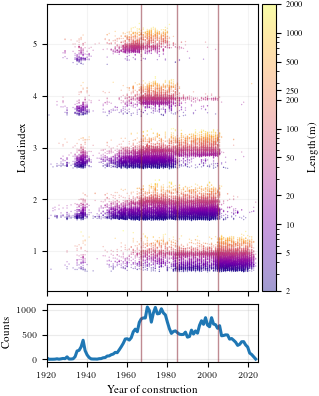

In [10]:
# 1) Imports & data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import colors, ticker
from matplotlib.ticker import FuncFormatter

from tueplots import bundles
from tueplots.constants.color import rgb


# Adjust path if needed
path = "../../data/final_bridge_statistic_germany.csv"
df = pd.read_csv(path, sep=";", encoding="latin1")

# Fix broken umlauts in column names
df.columns = (
    df.columns
      .str.replace("Ã¤", "ä", regex=False)
      .str.replace("Ã¼", "ü", regex=False)
      .str.replace("Ã¶", "ö", regex=False)
      .str.replace("Ã\x9c", "Ü", regex=False)
      .str.replace("Ã\x9f", "ß", regex=False)
)
df = df.rename(columns={"Baujahr Ã\x9cberbau": "Baujahr Überbau"})


# custom colormap for length (works with LogNorm)
custom_cmap = colors.LinearSegmentedColormap.from_list(
    "custom",
    [(0.0, "navy"),
     (0.1, "#585BFF"),
     (0.2, "lightgray"),
     (0.3, "#FC911E"),
     (0.7, "darkorange"),
     (1.0, "darkred")]
)


# 2) Helper: robust numeric conversion (handles commas)
def to_num(series):
    return pd.to_numeric(
        series.astype(str).str.replace(",", ".", regex=False),
        errors="coerce"
    )


# 3) Bridge-level aggregation
def prepare_bridge_level_data(df):
    df = df.copy()

    needed_cols = [
        "Bauwerksname", "Bundeslandname", "Zugeordneter Sachverhalt vereinfacht",
        "Baujahr Überbau", "Baujahr Unterbau", "Traglastindex",
        "Länge (m)", "Breite (m)"
    ]
    missing = [c for c in needed_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    # numeric conversion (comma-safe)
    for c in ["Breite (m)", "Länge (m)", "Traglastindex", "Baujahr Überbau", "Baujahr Unterbau"]:
        df[c] = to_num(df[c])

    # remove entire bridges if any row has width > 100
    bad_bridges = df.loc[df["Breite (m)"] > 100, "Bauwerksname"].dropna().unique()
    df = df[~df["Bauwerksname"].isin(bad_bridges)].copy()

    # each bridge must map to exactly one federal state
    bl_nunique = df.groupby("Bauwerksname")["Bundeslandname"].nunique(dropna=False)
    bad_bl = bl_nunique[bl_nunique > 1].index
    df = df[~df["Bauwerksname"].isin(bad_bl)].copy()

    # row area
    df["area_m2_row"] = df["Länge (m)"] * df["Breite (m)"]

    # aggregate to bridge level
    bridges = df.groupby("Bauwerksname", dropna=True).agg(
        LoadIndex_min=("Traglastindex", "min"),
        Year_superstructure_min=("Baujahr Überbau", "min"),
        Year_substructure_min=("Baujahr Unterbau", "min"),
        Area_m2_sum=("area_m2_row", "sum"),
        Length_m_sum=("Länge (m)", "sum"),
        FederalState=("Bundeslandname", "first"),
        Dataset=("Zugeordneter Sachverhalt vereinfacht", "first"),
    ).reset_index()

    # filters
    bridges = bridges[np.isfinite(bridges["LoadIndex_min"])].copy()
    bridges = bridges[np.isfinite(bridges["Year_superstructure_min"])].copy()
    bridges = bridges[np.isfinite(bridges["Area_m2_sum"])].copy()
    bridges = bridges[bridges["Area_m2_sum"] > 0].copy()

    bridges["Year_superstructure_min"] = pd.to_numeric(
        bridges["Year_superstructure_min"], errors="coerce"
    ).astype(int)

    return bridges


# 4) Plot function (tueplots-compatible, continuous LOG color, fixed vmax)
def plot_load_by_year_one_plot(cfg, df_bridge, title, savepath=None):
    d = df_bridge.copy()

    d["year"] = pd.to_numeric(d[cfg["year_col"]], errors="coerce")
    d["y"] = pd.to_numeric(d[cfg["load_col"]], errors="coerce")

    if cfg["size_var"] == "area":
        d["size_val"] = pd.to_numeric(d[cfg["area_col"]], errors="coerce")
        size_label = "m$^2$" if plt.rcParams.get("text.usetex", False) else "m²"
        cbar_label = f"Area ({size_label})"
    elif cfg["size_var"] == "length":
        d["size_val"] = pd.to_numeric(d[cfg["length_col"]], errors="coerce")
        size_label = "m"
        cbar_label = f"Length ({size_label})"
    else:
        raise ValueError("cfg['size_var'] must be 'area' or 'length'")

    d = d[np.isfinite(d["year"]) & np.isfinite(d["y"]) & np.isfinite(d["size_val"])].copy()
    d["year"] = d["year"].astype(int)
    d = d[(d["year"] >= cfg["year_min"]) & (d["year"] <= cfg["year_max"])].copy()

    # Log color needs strictly positive values
    d = d[d["size_val"] > 0].copy()

    if len(d) == 0:
        print(f"{title}: no data in range {cfg['year_min']}-{cfg['year_max']}")
        return

    # base y levels (load index stays the main y-axis levels)
    d["y_base"] = d["y"] * cfg["y_gap"]

    # ordered vertical offset by size (larger size -> higher inside each y level)
    sv = d["size_val"].to_numpy()
    if cfg.get("offset_use_log", True):
        lv = np.log1p(sv)
    else:
        lv = sv

    lv_min, lv_max = lv.min(), lv.max()
    norm_y = np.zeros_like(lv) if lv_max == lv_min else (lv - lv_min) / (lv_max - lv_min)
    offset = (norm_y - 0.5) * cfg["y_span"]

    jb = float(cfg.get("jitter_base", 0.0))
    if jb > 0:
        rng = np.random.default_rng(cfg["seed"])
        offset = offset + rng.uniform(-jb, jb, size=len(offset))

    d["offset"] = offset

    # --- color scale (LOG) with editable vmax ---
    vmin_data = float(np.nanmin(d["size_val"].to_numpy()))
    vmax_data = float(np.nanmax(d["size_val"].to_numpy()))

    vmin_cfg = cfg.get("cbar_vmin", None)
    vmax_cfg = cfg.get("cbar_vmax", None)

    vmin = vmin_data if vmin_cfg is None else float(vmin_cfg)
    vmax = vmax_data if vmax_cfg is None else float(vmax_cfg)

    vmin = max(vmin, np.finfo(float).tiny)
    if vmax <= vmin:
        vmax = vmin * 10.0

    # clip values so everything above vmax saturates at max color
    color_vals = np.clip(d["size_val"].to_numpy(), vmin, vmax)

    norm = colors.LogNorm(vmin=vmin, vmax=vmax)

    # allow passing a colormap object directly
    cmap = plt.get_cmap(cfg["cmap"]) if isinstance(cfg["cmap"], str) else cfg["cmap"]

    fig, axes = plt.subplots(
        2, 1,
        sharex=True,
        gridspec_kw={"height_ratios": cfg["height_ratios"]},
        layout="constrained"
    )
    ax = axes[0]
    ax_line = axes[1]

    sc = ax.scatter(
        d["year"],
        d["y_base"] + d["offset"],
        c=color_vals,
        cmap=cmap,
        norm=norm,
        s=cfg["point_size"],
        alpha=cfg["point_alpha"],
        linewidths=0,
        edgecolors="none",
        rasterized=True
    )

    # vertical code-change lines
    for yr in cfg["code_change_years"]:
        if cfg["year_min"] <= yr <= cfg["year_max"]:
            ax.axvline(
                yr,
                linewidth=cfg["vline_width"],
                alpha=cfg["vline_alpha"],
                linestyle="-",
                color=cfg["vline_color"]
            )

    # no title
    ax.set_ylabel(cfg["ylabel"])
    ax.set_xlim(cfg["year_min"], cfg["year_max"])
    ax.grid(True, alpha=cfg["grid_alpha"])

    y_levels = sorted(d["y"].dropna().unique())
    ax.set_yticks([y * cfg["y_gap"] for y in y_levels])
    ax.set_yticklabels([str(int(y)) if float(y).is_integer() else str(y) for y in y_levels])

    ax.set_ylim(
        d["y_base"].min() - (cfg["y_span"] + cfg["y_pad"]),
        d["y_base"].max() + (cfg["y_span"] + cfg["y_pad"])
    )

    # remove xlabel from top plot, hide tick labels
    ax.tick_params(axis="x", which="both", labelbottom=False)

    # colorbar (extend max when fixed vmax cuts off)
    extend_mode = "max" if (vmax_cfg is not None and vmax < vmax_data) else "neither"
    cbar = fig.colorbar(sc, ax=ax, pad=0.02, extend=extend_mode)
    cbar.set_label(cbar_label)

    # ticks: include clear min/max + sensitive steps
    candidates = np.array([1, 2, 5, 10, 20, 50, 100, 200, 250, 500, 1000, 2000], dtype=float)
    ticks = [vmin] + [x for x in candidates if (x >= vmin and x <= vmax)] + [vmax]
    ticks = np.unique(np.array(ticks, dtype=float))
    ticks = ticks[np.isfinite(ticks)]
    ticks = np.sort(ticks)
    if len(ticks) >= 2:
        cbar.set_ticks(ticks)

    def _fmt(x, _pos):
        if np.isfinite(x) and abs(x - round(x)) < 1e-9:
            return str(int(round(x)))
        return f"{x:.2f}".rstrip("0").rstrip(".")
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(_fmt))

    # bottom plot: counts per year
    counts = d.groupby("year").size().sort_index()
    ax_line.plot(counts.index.to_numpy(), counts.to_numpy(), linewidth=cfg["line_width"])

    for yr in cfg["code_change_years"]:
        if cfg["year_min"] <= yr <= cfg["year_max"]:
            ax_line.axvline(
                yr,
                linewidth=cfg["vline_width"],
                alpha=cfg["vline_alpha"],
                linestyle="-",
                color=cfg["vline_color"]
            )

    # x label only on bottom plot
    ax_line.set_xlabel(cfg["xlabel"])
    ax_line.set_ylabel("Counts")
    ax_line.set_xlim(cfg["year_min"], cfg["year_max"])
    ax_line.grid(True, alpha=cfg["grid_alpha_line"])

    if savepath is not None:
        fig.savefig(savepath, bbox_inches="tight")
    plt.show()


# 5) Style + run (tueplots)
plt.rcParams.update(bundles.icml2024(column="half", nrows=2, ncols=1, usetex=True))

cfg = {
    "year_col": "Year_superstructure_min",
    "load_col": "LoadIndex_min",
    "area_col": "Area_m2_sum",
    "length_col": "Length_m_sum",

    # choose size variable for coloring + ordering: "area" or "length"
    "size_var": "length",

    "year_min": 1920,
    "year_max": 2025,

    # y layout
    "y_span": 3.5,
    "y_gap": 4.5,
    "y_pad": 0.0,

    # ordering: larger size -> higher offset (use log for spacing)
    "offset_use_log": True,

    # set to 0.0 if you want fully strict ordering
    "jitter_base": 0.10,

    "height_ratios": [5, 1],

    # custom colormap
    "cmap": 'plasma',

    # colorbar range (2000m -> top color)
    "cbar_vmin": None,
    "cbar_vmax": 2000.0,

    # points
    "point_size": 1,
    "point_alpha": 0.40,

    # lines/grids
    "line_width": 2.2,
    "grid_alpha": 0.15,
    "grid_alpha_line": 0.25,

    "xlabel": "Year of construction",
    "ylabel": "Load index",

    "code_change_years": [1967, 1985, 2005],
    "vline_color": rgb.tue_red,
    "vline_width": 1.0,
    "vline_alpha": 0.55,

    "seed": 42,
}

bridges = prepare_bridge_level_data(df)

plot_load_by_year_one_plot(
    cfg,
    bridges,
    "",
    savepath="../plots_for_report/loadindex.pdf"
)
